In [10]:
# =========================
# Low-RAM loader with tqdm
# =========================
!pip -q install pyarrow fastparquet tqdm
from pathlib import Path
import pandas as pd
import random
import os, glob, gc
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
!pip -q install statsmodels


DATA_PATH = "C:/Users/Priyanka/Desktop/smart-energysystem/Data"           # CSVs are here
OUT_DIR   = "C:/Users/Priyanka/Desktop/smart-energysystem/Processed"  # where we'll write parquet
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Append a DF to a parquet file (streaming)
# ---------------------------
def append_to_parquet(df: pd.DataFrame, out_path: str):
    table = pa.Table.from_pandas(df, preserve_index=False)
    if not os.path.exists(out_path):
        pq.write_table(table, out_path, compression="snappy")
    else:
        with pq.ParquetWriter(out_path, table.schema, compression="snappy") as writer:
            writer.write_table(table)

# ---------------------------
# POWER files: H#_W*.csv  → processed/power.parquet
#    We keep: timestamp, household_id, power_W (float32)
# ---------------------------
power_out = os.path.join(OUT_DIR, "power.parquet")
if os.path.exists(power_out):
    os.remove(power_out)

power_files = sorted(glob.glob(os.path.join(DATA_PATH, "H*_W*.csv")))
print(f"Found {len(power_files)} power files")

for file in tqdm(power_files, desc="Loading POWER files"):
    hh_id = os.path.basename(file).split("_")[0]  # "H1" from "H1_W.csv"

    # read minimally to save RAM; low_memory avoids dtype thrash
    df = pd.read_csv(file, low_memory=False)
    # first column is datetime in StoreNet, second is active power (W)
    # be tolerant to column names/extra columns:
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors="coerce")
    df = df.rename(columns={df.columns[0]: "timestamp", df.columns[1]: "power_W"})
    # keep only what we need
    df = df[["timestamp", "power_W"]].copy()
    # set types & add household_id
    df["household_id"] = hh_id
    df = df.dropna(subset=["timestamp"])
    # downcast to save memory
    df["power_W"] = pd.to_numeric(df["power_W"], errors="coerce").astype("float32")
    df = df.dropna(subset=["power_W"])

    append_to_parquet(df, power_out)

    # free memory
    del df
    gc.collect()

# Quick check
pf = pq.read_table(power_out)
print("POWER rows written:", pf.num_rows)




[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 39 power files



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading POWER files:   0%|          | 0/39 [00:00<?, ?it/s]

POWER rows written: 527039


In [11]:

# ---------------------------
# ENERGY files: H#_Wh*.csv → processed/energy.parquet
#    We keep: timestamp, household_id, energy_Wh (float32)
# ---------------------------
energy_out = os.path.join(OUT_DIR, "energy.parquet")
if os.path.exists(energy_out):
    os.remove(energy_out)

energy_files = sorted(glob.glob(os.path.join(DATA_PATH, "H*_Wh*.csv")))
print(f"Found {len(energy_files)} energy files")

for file in tqdm(energy_files, desc="Loading ENERGY files"):
    hh_id = os.path.basename(file).split("_")[0]

    df = pd.read_csv(file, low_memory=False)
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors="coerce")
    df = df.rename(columns={df.columns[0]: "timestamp", df.columns[1]: "energy_Wh"})
    df = df[["timestamp", "energy_Wh"]].copy()
    df["household_id"] = hh_id
    df = df.dropna(subset=["timestamp"])
    df["energy_Wh"] = pd.to_numeric(df["energy_Wh"], errors="coerce").astype("float32")
    df = df.dropna(subset=["energy_Wh"])

    append_to_parquet(df, energy_out)

    del df
    gc.collect()

# Quick check
ef = pq.read_table(energy_out)
print("ENERGY rows written:", ef.num_rows)


Found 19 energy files


Loading ENERGY files:   0%|          | 0/19 [00:00<?, ?it/s]

ENERGY rows written: 527039


In [12]:

# ---------------------------
# WEATHER file(s) → processed/weather.parquet
#    We keep: timestamp + ['speed','drybulb','soltot','rain'] (float32)
#    Accepts names like "Weather data.csv", "weather.csv", etc.
# ---------------------------
weather_out = os.path.join(OUT_DIR, "weather.parquet")
if os.path.exists(weather_out):
    os.remove(weather_out)

weather_candidates = []
weather_candidates += glob.glob(os.path.join(DATA_PATH, "Weather*.csv"))
weather_candidates += glob.glob(os.path.join(DATA_PATH, "*weather*.csv"))
weather_candidates = sorted(set(weather_candidates))

if not weather_candidates:
    print("No weather CSV found in /content. Skipping weather.")
else:
    # Choose the largest (usually the main file)
    weather_path = max(weather_candidates, key=os.path.getsize)
    print("Using weather file:", os.path.basename(weather_path))

    w = pd.read_csv(weather_path, low_memory=False)
    # standardize names
    w.columns = [c.strip().lower() for c in w.columns]
    # figure timestamp column
    if "timestamp" in w.columns:
        ts_col = "timestamp"
    else:
        ts_col = "date" if "date" in w.columns else w.columns[0]

    w[ts_col] = pd.to_datetime(w[ts_col], errors="coerce")
    w = w.dropna(subset=[ts_col]).rename(columns={ts_col: "timestamp"})

    keep = ["timestamp", "speed", "drybulb", "soltot", "rain"]
    existing = [c for c in keep if c in w.columns]

    # clean numeric columns (strip blanks, coerce)
    for c in existing:
        if c != "timestamp":
            w[c] = (
                w[c].astype(str).str.strip()
                .replace({"": np.nan, "-": np.nan, "—": np.nan, "NA": np.nan, "NaN": np.nan, "nan": np.nan})
            )
            w[c] = pd.to_numeric(w[c], errors="coerce").astype("float32")

    w = w[existing].sort_values("timestamp")
    # optional: enforce 1-min grid and fill tiny gaps (keeps memory low)
    w = w.set_index("timestamp").asfreq("1min")
    for c in existing:
        if c != "timestamp":
            w[c] = w[c].interpolate(limit=3).ffill()

    w = w.reset_index()
    append_to_parquet(w, weather_out)

    del w
    gc.collect()

# Quick check
if os.path.exists(weather_out):
    wf = pq.read_table(weather_out)
    print("WEATHER rows written:", wf.num_rows)

print("All done. Parquet files are in:", OUT_DIR)

Using weather file: weather.csv
WEATHER rows written: 499680
All done. Parquet files are in: C:/Users/Priyanka/Desktop/smart-energysystem/Processed


Randomly selected household: H9


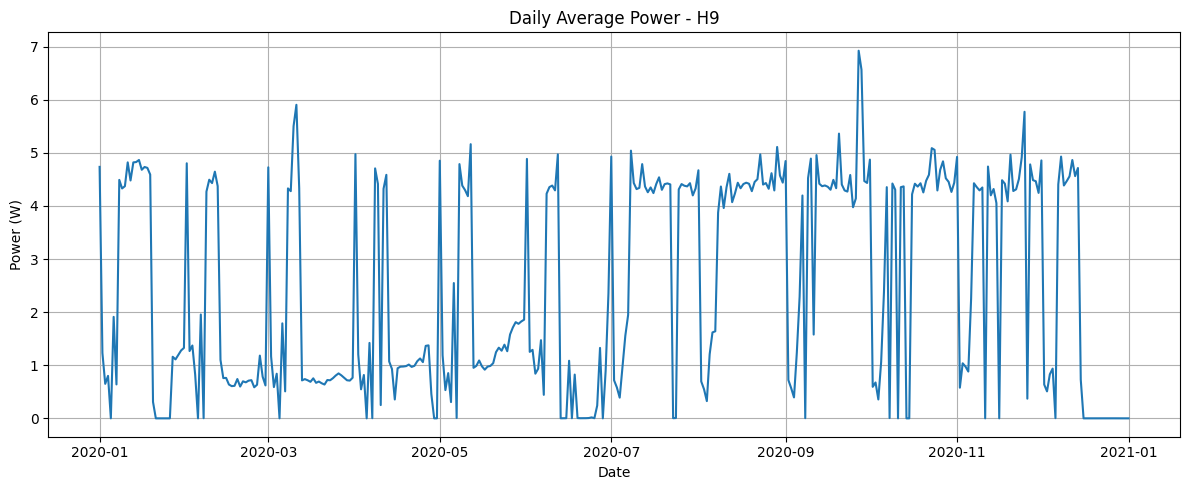

In [14]:
# ==== EDA: StoreNet (power.parquet, energy.parquet, weather.parquet) ====
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

POWER_PATH = "C:/Users/Priyanka/Desktop/smart-energysystem/Processed/power.parquet"
ENERGY_PATH = "C:/Users/Priyanka/Desktop/smart-energysystem/Processed/energy.parquet"
WEATHER_PATH = "C:/Users/Priyanka/Desktop/smart-energysystem/Processed/weather.parquet"

# Load
df_power  = pd.read_parquet(POWER_PATH)     # requires pyarrow or fastparquet
df_energy = pd.read_parquet(ENERGY_PATH)
df_weather= pd.read_parquet(WEATHER_PATH)

for df in (df_power, df_energy, df_weather):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Pick a random household
households = df_power["household_id"].unique().tolist()
sample_house = random.choice(households)
print("Randomly selected household:", sample_house)

# Daily avg power (random household)
daily_power = (df_power[df_power["household_id"] == sample_house]
               .set_index("timestamp")["power_W"]
               .resample("D").mean())

plt.figure(figsize=(12,5))
plt.plot(daily_power.index, daily_power.values)
plt.title(f"Daily Average Power - {sample_house}")
plt.xlabel("Date"); plt.ylabel("Power (W)"); plt.grid(True); plt.tight_layout(); plt.show()


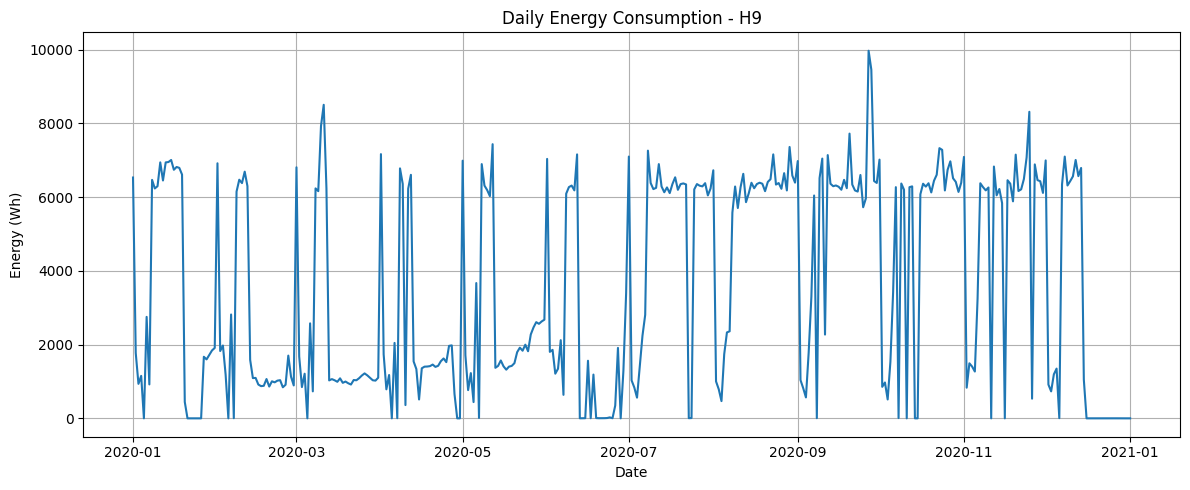

In [15]:
# Daily energy (random household)
daily_energy = (df_energy[df_energy["household_id"] == sample_house]
                .set_index("timestamp")["energy_Wh"]
                .resample("D").sum())

plt.figure(figsize=(12,5))
plt.plot(daily_energy.index, daily_energy.values)
plt.title(f"Daily Energy Consumption - {sample_house}")
plt.xlabel("Date"); plt.ylabel("Energy (Wh)"); plt.grid(True); plt.tight_layout(); plt.show()


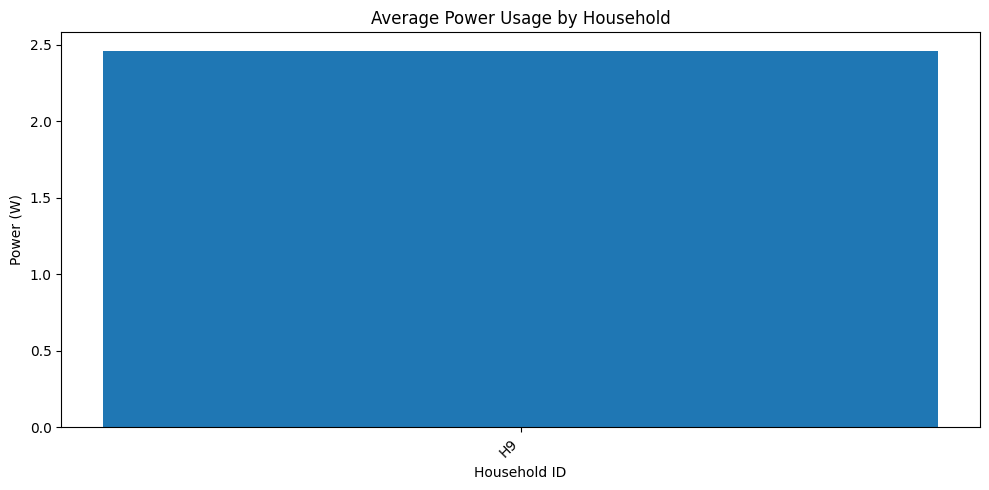

In [16]:
# Average power across households (bar)
avg_power_by_house = (df_power.groupby("household_id")["power_W"]
                      .mean().sort_values(ascending=False))

plt.figure(figsize=(10,5))
plt.bar(avg_power_by_house.index.astype(str), avg_power_by_house.values)
plt.title("Average Power Usage by Household")
plt.xlabel("Household ID"); plt.ylabel("Power (W)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

C:\Users\Priyanka\AppData\Local\Temp\ipykernel_6956\2102638868.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H").mean(numeric_only=True)


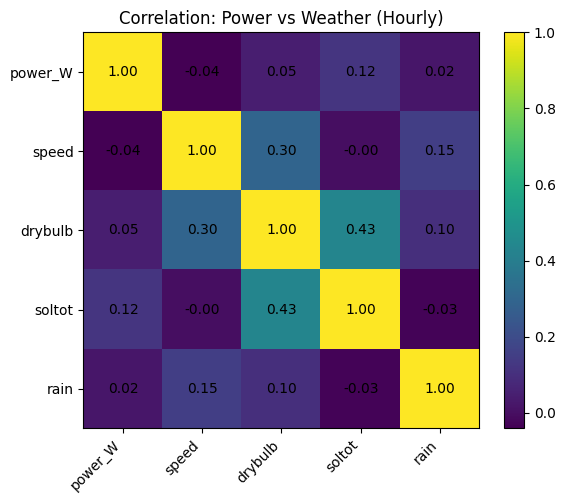

In [17]:

# Correlation: power vs weather (hourly)
df_pw = pd.merge(df_power, df_weather, on="timestamp", how="left")
pw_hourly = (df_pw.set_index("timestamp")
                 .groupby("household_id")
                 .resample("1H").mean(numeric_only=True)
                 .reset_index())

corr_cols = [c for c in ["power_W","speed","drybulb","soltot","rain"] if c in pw_hourly.columns]
corr_m = pw_hourly[corr_cols].corr().values

plt.figure(figsize=(6,5))
plt.imshow(corr_m, interpolation="nearest")
plt.title("Correlation: Power vs Weather (Hourly)")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        val = corr_m[i, j]
        if not np.isnan(val):
            plt.text(j, i, f"{val:.2f}", ha="center", va="center")
plt.colorbar()
plt.tight_layout(); plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import gc

# === Load parquet files ===
df_power  = pd.read_parquet("C:/Users/Priyanka/Desktop/smart-energysystem/Processed/power.parquet")
df_energy = pd.read_parquet("C:/Users/Priyanka/Desktop/smart-energysystem/Processed/energy.parquet")
df_weather= pd.read_parquet("C:/Users/Priyanka/Desktop/smart-energysystem/Processed/weather.parquet")

for df in (df_power, df_energy, df_weather):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# === Merge datasets ===
df = pd.merge(df_power, df_energy, on=["timestamp", "household_id"], how="outer")
df = pd.merge(df, df_weather, on="timestamp", how="left")

# Remove rows without timestamp or power
df = df.dropna(subset=["timestamp", "power_W"])

# === Aggregate to hourly ===
df = df.set_index("timestamp").groupby("household_id").resample("1H").mean(numeric_only=True).reset_index()

# === Time-based features ===
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["season"] = df["month"] % 12 // 3 + 1  # 1=winter, 2=spring, etc.

# === Drop timestamp for model input ===
df_model = df.drop(columns=["timestamp"])

# === One-hot encode household_id ===
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
house_encoded = encoder.fit_transform(df_model[["household_id"]])
house_cols = [f"house_{h}" for h in encoder.categories_[0]]
df_house = pd.DataFrame(house_encoded, columns=house_cols, index=df_model.index)

# Remove old household_id col and concat encoded
df_model = pd.concat([df_model.drop(columns=["household_id"]), df_house], axis=1)

# === Handle missing values ===
df_model = df_model.fillna(0)

# === Scale numeric features ===
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_model)
df_scaled = pd.DataFrame(scaled_array, columns=df_model.columns)

# === Train/test split ===
# Example: predict "power_W" using all other features
X = df_scaled.drop(columns=["power_W"])
y = df_scaled["power_W"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # no shuffling for time-series

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Free memory
gc.collect()


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# ----------------------------
# Core regression metrics
# ----------------------------
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mape_safe(y_true, y_pred):
    eps = K.epsilon()
    return 100.0 * tf.reduce_mean(tf.abs((y_true - y_pred) / (tf.abs(y_true) + eps)))

def smape(y_true, y_pred):
    eps = K.epsilon()
    num = tf.abs(y_pred - y_true)
    den = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + eps
    return 100.0 * tf.reduce_mean(num / den)

# ----------------------------------------------------
# Band accuracy (within absolute OR relative error)
#    Use creator functions so you can register as metrics
# ----------------------------------------------------
def make_rel_accuracy(rel_tol=0.10):
    """Fraction of samples with |err|/|true| <= rel_tol (e.g., 0.10 = 10%)."""
    eps = K.epsilon()
    def _metric(y_true, y_pred):
        rel_err = tf.abs(y_pred - y_true) / (tf.abs(y_true) + eps)
        return tf.reduce_mean(tf.cast(rel_err <= rel_tol, tf.float32))
    _metric.__name__ = f"acc_rel_{int(rel_tol*100)}pct"
    return _metric

def make_abs_accuracy(abs_tol=0.05):
    """Fraction of samples with |err| <= abs_tol (works on scaled targets too)."""
    def _metric(y_true, y_pred):
        err = tf.abs(y_pred - y_true)
        return tf.reduce_mean(tf.cast(err <= abs_tol, tf.float32))
    _metric.__name__ = f"acc_abs_{abs_tol}".replace('.','p')
    return _metric

# ----------------------------------------------------
# Soft IoU for bounded [0,1] targets
#    Safer than hard thresholding; use as a *metric*.
# ----------------------------------------------------
def soft_iou(y_true, y_pred):
    eps = K.epsilon()
    # If your targets are scaled to [0,1], this behaves well.
    a = tf.clip_by_value(y_true, 0.0, 1.0)
    b = tf.clip_by_value(y_pred, 0.0, 1.0)
    inter = tf.reduce_sum(tf.minimum(a, b))
    union = tf.reduce_sum(tf.maximum(a, b)) + eps
    return inter / union

# ----------------------------------------------------
# Losses
#    Use Huber (robust) + small MAE term. Avoid IoU inside loss (non-smooth).
# ----------------------------------------------------
def huber_plus_mae(delta=0.5, lam=0.3):
    """
    Hybrid loss = Huber(delta) + lam * MAE.
    delta: Huber transition; lam: weight of MAE term.
    """
    huber = tf.keras.losses.Huber(delta=delta, reduction=tf.keras.losses.Reduction.NONE)
    def _loss(y_true, y_pred):
        l_h = huber(y_true, y_pred)            # per-sample
        l_mae = tf.abs(y_true - y_pred)
        return tf.reduce_mean(l_h + lam * l_mae)
    return _loss

# --------------------------------------------------------------------
# Weighted loss emphasizing high-load samples on demand
# --------------------------------------------------------------------
def load_aware_huber(delta=0.5, alpha=0.5):
    """
    Increases penalty when y_true is large.
    weight = 1 + alpha * normalized_y_true  (assume y is ~[0,1] after scaling)
    """
    base = tf.keras.losses.Huber(delta=delta, reduction=tf.keras.losses.Reduction.NONE)
    def _loss(y_true, y_pred):
        w = 1.0 + alpha * tf.stop_gradient(tf.clip_by_value(y_true, 0.0, 1.0))
        return tf.reduce_mean(w * base(y_true, y_pred))
    return _loss


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---- assumes you've already defined the helpers:
# mae, rmse, mape_safe, smape, make_rel_accuracy, soft_iou, huber_plus_mae ----

def build_ecla_model(
    seq_len: int,
    n_seq_features: int,
    n_context: int,
    out_steps: int = 1,
    edge_friendly: bool = False,
    lr: float = 1e-3,
    loss_reg=None,
    metrics_reg=None,
    cls_loss="binary_crossentropy",
    cls_loss_weight: float = 0.30,
):
    """
    ECLA = Encoder (Conv1D + BiLSTM) + Context encoder + (Additive) Attention + dual heads.
    - edge_friendly=True uses smaller channel sizes for fast, low-latency inference.
    - No external globals required; compile happens inside with robust defaults.
    """

    # -------- capacities (edge-friendly downsizing) --------
    ch      = 32 if edge_friendly else 64
    lstm1   = 32 if edge_friendly else 64
    lstm2   = 16 if edge_friendly else 32
    dense_m = 64 if edge_friendly else 128
    ctx_m1  = 32 if edge_friendly else 64
    ctx_m2  = 16 if edge_friendly else 32
    drop_c  = 0.10
    drop_f  = 0.20

    # -------- sequence encoder --------
    inp_seq = layers.Input(shape=(seq_len, n_seq_features), name="X_seq")

    x = layers.Conv1D(ch, 3, padding="causal")(inp_seq)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(drop_c)(x)

    x = layers.Conv1D(ch, 3, padding="causal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(drop_c)(x)

    x = layers.Bidirectional(layers.LSTM(lstm1, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(lstm2, return_sequences=True))(x)

    # -------- additive attention over time --------
    score   = layers.Dense(64, activation="tanh")(x)            # (B,T,64)
    score   = layers.Dense(1, activation=None)(score)           # (B,T,1)
    weights = layers.Softmax(axis=1, name="temporal_weights")(score)
    context = layers.Dot(axes=1)([weights, x])                  # (B,1,F)
    context = layers.Reshape((-1,), name="temporal_context")(context)  # (B,F)

    # -------- exogenous/context encoder --------
    inp_ctx = layers.Input(shape=(n_context,), name="X_ctx")
    c = layers.Dense(ctx_m1, activation="relu")(inp_ctx)
    c = layers.Dropout(drop_c)(c)
    c = layers.Dense(ctx_m2, activation="relu")(c)

    # -------- fusion + heads --------
    fused = layers.Concatenate()([context, c])
    fused = layers.Dense(dense_m, activation="relu")(fused)
    fused = layers.Dropout(drop_f)(fused)

    # regression head (linear for out_steps)
    y_reg = layers.Dense(out_steps, name="y_reg")(fused)

    # classification head (high-load flag)
    y_cls = layers.Dense(1, activation="sigmoid", name="y_cls")(fused)

    model = Model(inputs=[inp_seq, inp_ctx], outputs=[y_reg, y_cls], name="ECLA")

    # -------- defaults for loss/metrics (robust & IoT-friendly) --------
    if loss_reg is None:
        loss_reg = huber_plus_mae(delta=0.5, lam=0.25)

    if metrics_reg is None:
        metrics_reg = [mae, rmse, mape_safe, smape, make_rel_accuracy(0.10), soft_iou]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss={"y_reg": loss_reg, "y_cls": cls_loss},
        loss_weights={"y_reg": 1.0, "y_cls": cls_loss_weight},
        metrics={"y_reg": metrics_reg,
                 "y_cls": ["accuracy", tf.keras.metrics.AUC(name="auc")]}
    )
    return model


In [ ]:
# --- metrics on *original* scale ---
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def reg_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=True) ** 0.5
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-9))) * 100.0
    r2   = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape, "R2": r2}

def show_metrics(name, y_true, y_pred):
    m = reg_metrics(y_true, y_pred)
    print(f"\n[{name}]  MAE={m['MAE']:.4f}  RMSE={m['RMSE']:.4f}  MAPE={m['MAPE%']:.2f}%  R2={m['R2']:.4f}")
    return m

# --- inverse-scale target from your MinMax scaler you used on df_model ---
# df_model_cols must be the *same* order you used when fitting scaler
def inverse_scale_target(y_scaled, df_model_cols, scaler):
    idx = df_model_cols.get_loc("power_W")
    data_min = scaler.data_min_[idx]
    data_max = scaler.data_max_[idx]
    return y_scaled * (data_max - data_min) + data_min

# Optional consolidated table
all_results = []
def add_row(name, y_true, y_pred, extra=None):
    row = {"Model": name, **reg_metrics(y_true, y_pred)}
    if extra: row.update(extra)
    all_results.append(row)


In [3]:
import numpy as np
import pandas as pd


cols = list(df_scaled.columns)

# Decide features by NAME (no magic -10)
seq_feat_names = ['power_W']
ctx_feat_names = [c for c in cols             # context = “current” exogenous features
                  if c not in seq_feat_names] # (time features + weather + household one-hots)


# seq_feat_names = ['power_W','speed','drybulb','soltot','rain']

seq_cols = np.array([cols.index(c) for c in seq_feat_names], dtype=int)
ctx_cols = np.array([cols.index(c) for c in ctx_feat_names], dtype=int)

seq_len   = 24
out_steps = 1

# ---- Build matrices from *scaled* full table so power_W exists in features ----
Xtr_full = np.asarray(df_scaled.iloc[:len(X_train)+len(X_test)].values)  # same ordering as your split
# Map train/test slices exactly as you used for X_train/X_test:
Xtr_np = np.asarray(df_scaled.iloc[:len(X_train)].values)
Xva_np = np.asarray(df_scaled.iloc[len(X_train):len(X_train)+len(X_test)].values)

# Targets (scaled) as you had:
ytr_np = np.asarray(y_train).reshape(-1)
yva_np = np.asarray(y_test).reshape(-1)

def build_seq_ctx(X_np, y_np, seq_len, seq_cols, ctx_cols, out_steps=1):
    """
    Returns:
      X_seq: (M, seq_len, len(seq_cols))  # rolling temporal window
      X_ctx: (M, len(ctx_cols))           # context at prediction time t
      Y:     (M, out_steps)
    """
    N = X_np.shape[0]
    X_seq, X_ctx, Y = [], [], []
    for i in range(N - seq_len - out_steps + 1):
        # sequence window over chosen seq features (e.g., power_W history)
        win_seq = X_np[i:i+seq_len, :]
        X_seq.append(win_seq[:, seq_cols])

        # context snapshot at prediction time t = i+seq_len-1
        X_ctx.append(X_np[i+seq_len-1, ctx_cols])

        # target(s) for next step(s)
        Y.append(y_np[i+seq_len:i+seq_len+out_steps])
    return np.array(X_seq), np.array(X_ctx), np.array(Y)

# ---- Build windows for train/val (no leakage; each split windowed independently) ----
X_seq_tr, X_ctx_tr, y_reg_tr = build_seq_ctx(Xtr_np, ytr_np, seq_len, seq_cols, ctx_cols, out_steps)
X_seq_va, X_ctx_va, y_reg_va = build_seq_ctx(Xva_np, yva_np, seq_len, seq_cols, ctx_cols, out_steps)

n_seq_features = X_seq_tr.shape[2]
n_context      = X_ctx_tr.shape[1]

# ---- Classification labels from *train split* only (good practice) ----
def make_cls_labels_splitwise(y_reg_array, q=0.8):
    flat = y_reg_array.reshape(-1)
    thr  = np.quantile(flat, q)
    ycls = (flat > thr).astype(np.float32).reshape(-1, 1)
    return ycls, float(thr)

y_cls_tr, thr_tr = make_cls_labels_splitwise(y_reg_tr, q=0.8)
y_cls_va, thr_va = make_cls_labels_splitwise(y_reg_va, q=0.8)
print(f"Train threshold (scaled): {thr_tr:.6f} | Val threshold (scaled): {thr_va:.6f}")


NameError: name 'df_scaled' is not defined

In [2]:
# ---------- latency for Naive & MA(3) using validation windows ----------
import time

# find which seq feature is power_W (default to 0 if unknown)
try:
    power_idx = seq_feat_names.index('power_W')
except Exception:
    power_idx = 0

def naive_predict_from_seq(X_seq, pidx=0):
    # last observed target in the window
    return X_seq[:, -1, pidx]

def ma_predict_from_seq(X_seq, pidx=0, k=3):
    k = min(k, X_seq.shape[1])
    return np.mean(X_seq[:, -k:, pidx], axis=1)

def latency_stats_ms_predictor(predict_fn, X_seq, reps=300, batch_size=1, name="model"):
    n = X_seq.shape[0]
    if n == 0:
        raise ValueError("X_seq has no rows")
    # warm-up
    _ = predict_fn(X_seq[:min(batch_size, n)])
    times = []
    idx = np.random.randint(0, n, size=reps*batch_size)
    for i in range(reps):
        start = i*batch_size
        xb = X_seq[idx[start:start+batch_size]]
        t0 = time.perf_counter()
        _ = predict_fn(xb)
        times.append((time.perf_counter() - t0)*1000.0)
    stats = {
        "Model": name,
        "Mean_ms":  float(np.mean(times)),
        "Median_ms":float(np.median(times)),
        "P90_ms":   float(np.percentile(times, 90)),
        "P99_ms":   float(np.percentile(times, 99)),
        "Batch":    int(batch_size),
        "Reps":     int(reps),
    }
    print(f"[Latency {name} (batch={batch_size})] "
          f"mean={stats['Mean_ms']:.4f} ms | p50={stats['Median_ms']:.4f} | "
          f"p90={stats['P90_ms']:.4f} | p99={stats['P99_ms']:.4f}")
    return stats

# ensure dtype
X_seq_va = np.asarray(X_seq_va).astype(np.float32)

naive_lat = latency_stats_ms_predictor(lambda X: naive_predict_from_seq(X, power_idx),
                                       X_seq_va, reps=300, batch_size=1, name="Naive(last)")
ma3_lat   = latency_stats_ms_predictor(lambda X: ma_predict_from_seq(X, power_idx, 3),
                                       X_seq_va, reps=300, batch_size=1, name="MA(3)")

# keep handy for final results table
naive_latency_ms = naive_lat["Mean_ms"]
ma3_latency_ms   = ma3_lat["Mean_ms"]


NameError: name 'X_seq_va' is not defined

In [ ]:
import warnings, pandas as pd, numpy as np, time
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

# --- make a clean hourly dataframe for ARIMA (only what we need) ---
df_ar_src = (df.loc[:, ["timestamp", "household_id", "power_W"]]
               .dropna(subset=["timestamp", "power_W"])
               .copy())
df_ar_src["timestamp"] = pd.to_datetime(df_ar_src["timestamp"], errors="coerce")
df_ar_src = df_ar_src.dropna(subset=["timestamp"]).sort_values(["household_id", "timestamp"])

# hourly mean per household
df_hourly = (df_ar_src
             .set_index("timestamp")
             .groupby("household_id")
             .resample("1H")["power_W"]
             .mean()
             .reset_index())

# --- time split (80% of overall time span across all households) ---
ts_sorted = np.array(sorted(df_hourly["timestamp"].unique()))
if len(ts_sorted) < 4:
    raise ValueError("Not enough hourly points for ARIMA split.")
split_time = ts_sorted[int(0.8 * len(ts_sorted))]

preds = []
models_info = []  # keep fitted models + their test index for latency measurement

for hh in df_hourly["household_id"].unique():
    s = (df_hourly.loc[df_hourly["household_id"] == hh, ["timestamp", "power_W"]]
                   .set_index("timestamp")["power_W"]
                   .asfreq("1H"))
    s = s.interpolate(limit=6).bfill().ffill()

    train = s.loc[:split_time]
    test  = s.loc[split_time + pd.Timedelta(hours=1):]

    if (train.shape[0] < 48) or (test.shape[0] < 1):
        continue

    try:
        mod = SARIMAX(train,
                      order=(1,1,1),
                      seasonal_order=(1,1,1,24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        res = mod.fit(disp=False)
        pred = res.predict(start=test.index[0], end=test.index[-1])

        preds.append(pd.DataFrame({
            "household_id": hh,
            "timestamp": test.index,
            "y_true": test.values,
            "y_pred": pred.values
        }))

        models_info.append({"household_id": hh, "res": res, "test_index": test.index})
    except Exception:
        continue

# ---- metrics + latency ----
def arima_latency_stats(models_info, reps_per_house=60, max_houses=5):
    """Time one-step predictions across up to max_houses models; return latency stats in ms."""
    times = []
    used = 0
    for info in models_info[:max_houses]:
        res = info["res"]
        t_idx = list(info["test_index"])
        if not t_idx:
            continue
        idxs = np.random.randint(0, len(t_idx), size=reps_per_house)
        for i in idxs:
            t = t_idx[i]
            t0 = time.perf_counter()
            _ = res.predict(start=t, end=t)   # one-step prediction
            times.append((time.perf_counter() - t0) * 1000.0)
        used += 1
    if not times:
        return None
    return {
        "Mean_ms":   float(np.mean(times)),
        "Median_ms": float(np.median(times)),
        "P90_ms":    float(np.percentile(times, 90)),
        "P99_ms":    float(np.percentile(times, 99)),
        "Calls":     int(len(times)),
        "Houses":    int(used)
    }

if not preds:
    print("ARIMA: No valid households to evaluate (not enough data after resampling?).")
else:
    df_arima = pd.concat(preds, ignore_index=True)
    _ = show_metrics("ARIMA per-household",
                     df_arima["y_true"].values, df_arima["y_pred"].values)

    # latency
    arima_lat_stats = arima_latency_stats(models_info, reps_per_house=60, max_houses=5)
    if arima_lat_stats is None:
        print("ARIMA latency: no test points to time.")
        arima_latency_ms = None
    else:
        print(f"[Latency ARIMA one-step] mean={arima_lat_stats['Mean_ms']:.3f} ms | "
              f"p50={arima_lat_stats['Median_ms']:.3f} | p90={arima_lat_stats['P90_ms']:.3f} | "
              f"p99={arima_lat_stats['P99_ms']:.3f}  "
              f"(calls={arima_lat_stats['Calls']}, houses={arima_lat_stats['Houses']})")
        arima_latency_ms = float(arima_lat_stats["Mean_ms"])

    # add to results (with latency if available)
    add_row(
        "ARIMA per-household",
        df_arima["y_true"].values,
        df_arima["y_pred"].values,
        extra=({"Latency_ms": arima_latency_ms} if arima_latency_ms is not None else None)
    )

    # also expose latency globally for the robust consolidation cell (optional)
    if arima_latency_ms is not None:
        globals()["arima_latency_ms"] = arima_latency_ms



[ARIMA per-household]  MAE=3.3391  RMSE=5.4407  MAPE=166612969033.47%  R2=0.1425
[Latency ARIMA one-step] mean=108.078 ms | p50=114.329 | p90=182.815 | p99=251.225  (calls=60, houses=1)


In [ ]:
# ==== Rebuild SVR/RF inputs & models if missing ====
import numpy as np, pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import time
import numpy as np

def latency_stats_ms(model, X, reps=300, batch_size=1, name="model", random_state=None):
    """
    Measure prediction latency (milliseconds) for a scikit-learn–style model.

    Parameters
    ----------
    model : object
        Must implement .predict(X_batch).
    X : np.ndarray
        Feature matrix to draw random batches from (no mutation).
    reps : int, default=300
        Number of timed predict() calls.
    batch_size : int, default=1
        Number of rows per predict() call (simulates online vs batched inference).
    name : str, default="model"
        Label printed in the summary and included in the returned dict.
    random_state : int or None
        Seed for reproducible sampling of indices.

    Returns
    -------
    dict
        {"Model","Mean_ms","Median_ms","P90_ms","P99_ms","Batch","Reps"}
    """
    X = np.asarray(X)
    n = X.shape[0]
    if n == 0:
        raise ValueError("X has no rows")
    if batch_size < 1:
        raise ValueError("batch_size must be >= 1")

    # Warm-up (fills caches/JIT paths)
    warm_n = min(max(batch_size, 8), n)
    _ = model.predict(X[:warm_n])

    # Random index generator
    rng = np.random.default_rng(random_state)
    idx = rng.integers(0, n, size=reps * batch_size)

    # Timed runs
    times = []
    for i in range(reps):
        start = i * batch_size
        end   = start + batch_size
        xb = X[idx[start:end]]
        t0 = time.perf_counter()
        _ = model.predict(xb)
        dt_ms = (time.perf_counter() - t0) * 1000.0
        times.append(dt_ms)

    times = np.array(times, dtype=float)
    stats = {
        "Model":     name,
        "Mean_ms":   float(np.mean(times)),
        "Median_ms": float(np.median(times)),
        "P90_ms":    float(np.percentile(times, 90)),
        "P99_ms":    float(np.percentile(times, 99)),
        "Batch":     int(batch_size),
        "Reps":      int(reps),
    }
    print(f"[Latency {name} (batch={batch_size})] "
          f"mean={stats['Mean_ms']:.3f} ms | p50={stats['Median_ms']:.3f} | "
          f"p90={stats['P90_ms']:.3f} | p99={stats['P99_ms']:.3f}")
    return stats

def make_lagged(df_in, lags=(1,2,3,24)):
    df2 = df_in.sort_values(["household_id","timestamp"]).copy()
    for L in lags:
        df2[f"power_W_lag{L}"] = df2.groupby("household_id")["power_W"].shift(L)
    return df2

def prepare_svr_rf(df, split_time=None):
    # choose available exogenous cols
    exog_cols = [c for c in ["speed","drybulb","soltot","rain","hour","dayofweek","month","is_weekend","season"]
                 if c in df.columns]
    base_cols = ["household_id","timestamp","power_W"] + exog_cols
    df_base = (df[base_cols]
               .dropna(subset=["timestamp","power_W"])
               .copy())
    df_base["timestamp"] = pd.to_datetime(df_base["timestamp"], errors="coerce")
    df_base = df_base.dropna(subset=["timestamp"])

    # lags & one-hot
    lagged = make_lagged(df_base, lags=(1,2,3,24)).dropna().reset_index(drop=True)
    lagged = pd.get_dummies(lagged, columns=["household_id"], drop_first=False)

    # time split
    if split_time is None:
        ts_sorted = np.array(sorted(lagged["timestamp"].unique()))
        if len(ts_sorted) < 4:
            raise ValueError("Not enough timestamps to create a split for SVR/RF.")
        split_time = ts_sorted[int(0.8 * len(ts_sorted))]

    train_idx = lagged["timestamp"] <= split_time
    test_idx  = lagged["timestamp"] >  split_time

    feat_cols = [c for c in lagged.columns if c not in ["timestamp","power_W"]]
    Xb_tr, Xb_va = lagged.loc[train_idx, feat_cols].values, lagged.loc[test_idx, feat_cols].values
    yb_tr, yb_va = lagged.loc[train_idx, "power_W"].values,  lagged.loc[test_idx,  "power_W"].values

    # train models
    svr = SVR(kernel="rbf", C=10, epsilon=0.05)
    svr.fit(Xb_tr, yb_tr)

    rf  = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, max_depth=None)
    rf.fit(Xb_tr, yb_tr)

    return svr, rf, Xb_va, yb_va, split_time

# Build if missing (or force rebuild)
if not all(name in globals() for name in ["svr","rf","Xb_va","yb_va"]):
    svr, rf, Xb_va, yb_va, split_time = prepare_svr_rf(df)
    print("SVR/RF inputs rebuilt:",
          f"Xb_va shape = {Xb_va.shape}, yb_va shape = {yb_va.shape}")
# ------------ Measure latency ------------
svr_lat_1 = latency_stats_ms(svr, Xb_va, reps=300, batch_size=1, name="SVR")
rf_lat_1  = latency_stats_ms(rf,  Xb_va, reps=300, batch_size=1, name="RandomForest")

# optional throughput with small batch
svr_lat_32 = latency_stats_ms(svr, Xb_va, reps=100, batch_size=32, name="SVR")
rf_lat_32  = latency_stats_ms(rf,  Xb_va, reps=100, batch_size=32, name="RandomForest")

svr_latency_ms = svr_lat_1["Mean_ms"]
rf_latency_ms  = rf_lat_1["Mean_ms"]




[Latency SVR (batch=1)] mean=1.144 ms | p50=0.878 | p90=1.224 | p99=7.637
[Latency RandomForest (batch=1)] mean=103.201 ms | p50=88.951 | p90=155.064 | p99=201.818
[Latency SVR (batch=32)] mean=8.576 ms | p50=8.320 | p90=8.902 | p99=14.941
[Latency RandomForest (batch=32)] mean=101.012 ms | p50=101.275 | p90=108.637 | p99=133.563


In [ ]:
# --- Train full ECLA ---
full = build_ecla_model(seq_len, n_seq_features, n_context,
                        out_steps=out_steps, edge_friendly=False, lr=1e-3)

cb = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
]

hist_full = full.fit(
    [X_seq_tr, X_ctx_tr], {"y_reg": y_reg_tr, "y_cls": (y_reg_tr > np.quantile(y_reg_tr, 0.8)).astype(np.float32)},
    validation_data=([X_seq_va, X_ctx_va], {"y_reg": y_reg_va, "y_cls": (y_reg_va > np.quantile(y_reg_va, 0.8)).astype(np.float32)}),
    epochs=50, batch_size=256, verbose=1, callbacks=cb
)

# Predict
y_reg_pred_full_scaled, y_cls_prob_full = full.predict([X_seq_va, X_ctx_va], batch_size=256, verbose=0)
y_reg_pred_full_scaled = y_reg_pred_full_scaled.reshape(-1)
y_reg_true_scaled      = y_reg_va.reshape(-1)

# Inverse-scale for metrics with other baselines
y_reg_pred_full = inverse_scale_target(y_reg_pred_full_scaled, df_model.columns, scaler)
y_reg_true      = inverse_scale_target(y_reg_true_scaled,      df_model.columns, scaler)

m_ecla_full = show_metrics("ECLA (full)", y_reg_true, y_reg_pred_full)
add_row("ECLA (full)", y_reg_true, y_reg_pred_full)

# --- Edge (smaller) ---
edge = build_ecla_model(seq_len, n_seq_features, n_context,
                        out_steps=out_steps, edge_friendly=True, lr=5e-4)

hist_edge = edge.fit(
    [X_seq_tr, X_ctx_tr], {"y_reg": y_reg_tr, "y_cls": (y_reg_tr > np.quantile(y_reg_tr, 0.8)).astype(np.float32)},
    validation_data=([X_seq_va, X_ctx_va], {"y_reg": y_reg_va, "y_cls": (y_reg_va > np.quantile(y_reg_va, 0.8)).astype(np.float32)}),
    epochs=30, batch_size=256, verbose=1, callbacks=cb
)

y_reg_pred_edge_scaled, _ = edge.predict([X_seq_va, X_ctx_va], batch_size=256, verbose=0)
y_reg_pred_edge_scaled = y_reg_pred_edge_scaled.reshape(-1)
y_reg_pred_edge = inverse_scale_target(y_reg_pred_edge_scaled, df_model.columns, scaler)

m_ecla_edge = show_metrics("ECLA (edge)", y_reg_true, y_reg_pred_edge)
add_row("ECLA (edge)", y_reg_true, y_reg_pred_edge)

# --- Latency (simulate edge batch=1) ---
def avg_latency_ms(model, reps=200):
    sample_seq = X_seq_va[:1]
    sample_ctx = X_ctx_va[:1]
    _ = model.predict([sample_seq, sample_ctx], verbose=0)  # warmup
    import time
    t0 = time.perf_counter()
    for _ in range(reps):
        _ = model.predict([sample_seq, sample_ctx], batch_size=1, verbose=0)
    return (time.perf_counter() - t0) / reps * 1000

lat_full_ms = avg_latency_ms(full)
lat_edge_ms = avg_latency_ms(edge)
print(f"\nInference latency (ms): FULL={lat_full_ms:.2f}   EDGE={lat_edge_ms:.2f}")


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 638ms/step - loss: 0.2109 - y_cls_accuracy: 0.7170 - y_cls_auc: 0.5330 - y_cls_loss: 0.5965 - y_reg_acc_rel_10pct: 0.0168 - y_reg_loss: 0.0320 - y_reg_mae: 0.0944 - y_reg_mape_safe: 43341888.0000 - y_reg_rmse: 0.1281 - y_reg_smape: 166.3907 - y_reg_soft_iou: 0.1797 - val_loss: 0.2013 - val_y_cls_accuracy: 0.7998 - val_y_cls_auc: 0.5692 - val_y_cls_loss: 0.5905 - val_y_reg_acc_rel_10pct: 0.0045 - val_y_reg_loss: 0.0227 - val_y_reg_mae: 0.0608 - val_y_reg_mape_safe: 8758075.0000 - val_y_reg_rmse: 0.1126 - val_y_reg_smape: 189.5169 - val_y_reg_soft_iou: 0.0447 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - loss: 0.1430 - y_cls_accuracy: 0.8352 - y_cls_auc: 0.8242 - y_cls_loss: 0.3946 - y_reg_acc_rel_10pct: 0.0218 - y_reg_loss: 0.0246 - y_reg_mae: 0.0761 - y_reg_mape_safe: 33009626.0000 - y_reg_rmse: 0.1058 - y_reg_smape: 157.6540 - y_reg_soft_iou: 0.3018 - val_loss: 0.1805 - val_y_cls_accuracy: 0.7998 - val_y_cls_au


[ECLA (full)]  MAE=3.0876  RMSE=6.1075  MAPE=56488837365.81%  R2=-0.0826
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - loss: 0.2078 - y_cls_accuracy: 0.7974 - y_cls_auc: 0.4894 - y_cls_loss: 0.6051 - y_reg_acc_rel_10pct: 0.0199 - y_reg_loss: 0.0263 - y_reg_mae: 0.0778 - y_reg_mape_safe: 31046280.0000 - y_reg_rmse: 0.1168 - y_reg_smape: 160.0208 - y_reg_soft_iou: 0.1723 - val_loss: 0.1982 - val_y_cls_accuracy: 0.7998 - val_y_cls_auc: 0.4820 - val_y_cls_loss: 0.5776 - val_y_reg_acc_rel_10pct: 0.0089 - val_y_reg_loss: 0.0234 - val_y_reg_mae: 0.0675 - val_y_reg_mape_safe: 22722452.0000 - val_y_reg_rmse: 0.1075 - val_y_reg_smape: 174.4840 - val_y_reg_soft_iou: 0.1115 - learning_rate: 5.0000e-04
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.1707 - y_cls_accuracy: 0.7993 - y_cls_auc: 0.6373 - y_cls_loss: 0.4872 - y_reg_acc_rel_10pct: 0.0158 - y_reg_loss: 0.0246 - y_reg_mae: 0.0739 - y_reg_mape_safe: 27290924.0000 - y_reg_rmse: 0.1111 - y_reg_smape: 164.2129 - y_reg_s

In [ ]:
# --- Train full ECLA ---
full = build_ecla_model(seq_len, n_seq_features, n_context,
                        out_steps=out_steps, edge_friendly=False, lr=1e-3)

cb = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
]

hist_full = full.fit(
    [X_seq_tr, X_ctx_tr], {"y_reg": y_reg_tr, "y_cls": (y_reg_tr > np.quantile(y_reg_tr, 0.8)).astype(np.float32)},
    validation_data=([X_seq_va, X_ctx_va], {"y_reg": y_reg_va, "y_cls": (y_reg_va > np.quantile(y_reg_va, 0.8)).astype(np.float32)}),
    epochs=50, batch_size=256, verbose=1, callbacks=cb
)

# Predict
y_reg_pred_full_scaled, y_cls_prob_full = full.predict([X_seq_va, X_ctx_va], batch_size=256, verbose=0)
y_reg_pred_full_scaled = y_reg_pred_full_scaled.reshape(-1)
y_reg_true_scaled      = y_reg_va.reshape(-1)

# Inverse-scale for metrics with other baselines
y_reg_pred_full = inverse_scale_target(y_reg_pred_full_scaled, df_model.columns, scaler)
y_reg_true      = inverse_scale_target(y_reg_true_scaled,      df_model.columns, scaler)

m_ecla_full = show_metrics("ECLA (full)", y_reg_true, y_reg_pred_full)
add_row("ECLA (full)", y_reg_true, y_reg_pred_full)

# --- Edge (smaller) ---
edge = build_ecla_model(seq_len, n_seq_features, n_context,
                        out_steps=out_steps, edge_friendly=True, lr=5e-4)

hist_edge = edge.fit(
    [X_seq_tr, X_ctx_tr], {"y_reg": y_reg_tr, "y_cls": (y_reg_tr > np.quantile(y_reg_tr, 0.8)).astype(np.float32)},
    validation_data=([X_seq_va, X_ctx_va], {"y_reg": y_reg_va, "y_cls": (y_reg_va > np.quantile(y_reg_va, 0.8)).astype(np.float32)}),
    epochs=30, batch_size=256, verbose=1, callbacks=cb
)

y_reg_pred_edge_scaled, _ = edge.predict([X_seq_va, X_ctx_va], batch_size=256, verbose=0)
y_reg_pred_edge_scaled = y_reg_pred_edge_scaled.reshape(-1)
y_reg_pred_edge = inverse_scale_target(y_reg_pred_edge_scaled, df_model.columns, scaler)

m_ecla_edge = show_metrics("ECLA (edge)", y_reg_true, y_reg_pred_edge)
add_row("ECLA (edge)", y_reg_true, y_reg_pred_edge)

# --- Latency (simulate edge batch=1) ---
def avg_latency_ms(model, reps=200):
    sample_seq = X_seq_va[:1]
    sample_ctx = X_ctx_va[:1]
    _ = model.predict([sample_seq, sample_ctx], verbose=0)  # warmup
    import time
    t0 = time.perf_counter()
    for _ in range(reps):
        _ = model.predict([sample_seq, sample_ctx], batch_size=1, verbose=0)
    return (time.perf_counter() - t0) / reps * 1000

lat_full_ms = avg_latency_ms(full)
lat_edge_ms = avg_latency_ms(edge)
print(f"\nInference latency (ms): FULL={lat_full_ms:.2f}   EDGE={lat_edge_ms:.2f}")


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 366ms/step - loss: 0.2081 - y_cls_accuracy: 0.7323 - y_cls_auc: 0.5721 - y_cls_loss: 0.5927 - y_reg_acc_rel_10pct: 0.0181 - y_reg_loss: 0.0302 - y_reg_mae: 0.0896 - y_reg_mape_safe: 37339332.0000 - y_reg_rmse: 0.1236 - y_reg_smape: 165.2314 - y_reg_soft_iou: 0.1830 - val_loss: 0.1958 - val_y_cls_accuracy: 0.7998 - val_y_cls_auc: 0.6098 - val_y_cls_loss: 0.5790 - val_y_reg_acc_rel_10pct: 0.0134 - val_y_reg_loss: 0.0207 - val_y_reg_mae: 0.0597 - val_y_reg_mape_safe: 17858458.0000 - val_y_reg_rmse: 0.1005 - val_y_reg_smape: 170.0810 - val_y_reg_soft_iou: 0.1439 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - loss: 0.1431 - y_cls_accuracy: 0.8248 - y_cls_auc: 0.8292 - y_cls_loss: 0.3955 - y_reg_acc_rel_10pct: 0.0264 - y_reg_loss: 0.0244 - y_reg_mae: 0.0753 - y_reg_mape_safe: 33729032.0000 - y_reg_rmse: 0.1054 - y_reg_smape: 158.5914 - y_reg_soft_iou: 0.3022 - val_loss: 0.1703 - val_y_cls_accuracy: 0.7998 - val_y_cls_au

  0%|          | 0/300 [00:00<?, ?it/s]

,feature,mean_abs_shap
0,energy_Wh,0.004864
1,is_weekend,0.001892
2,speed,0.001581
3,hour,0.001580
4,season,0.001481
5,dayofweek,0.001371
6,soltot,0.001290
7,month,0.001181
8,drybulb,0.001020
9,rain,0.000652


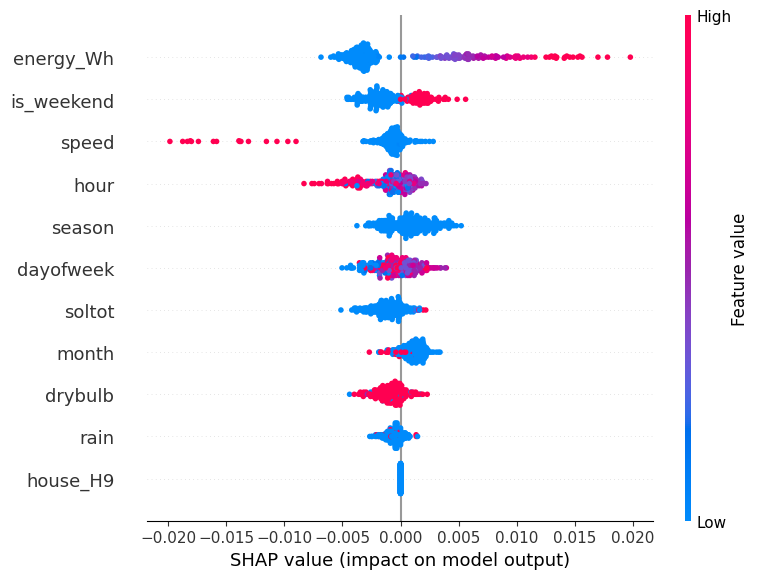

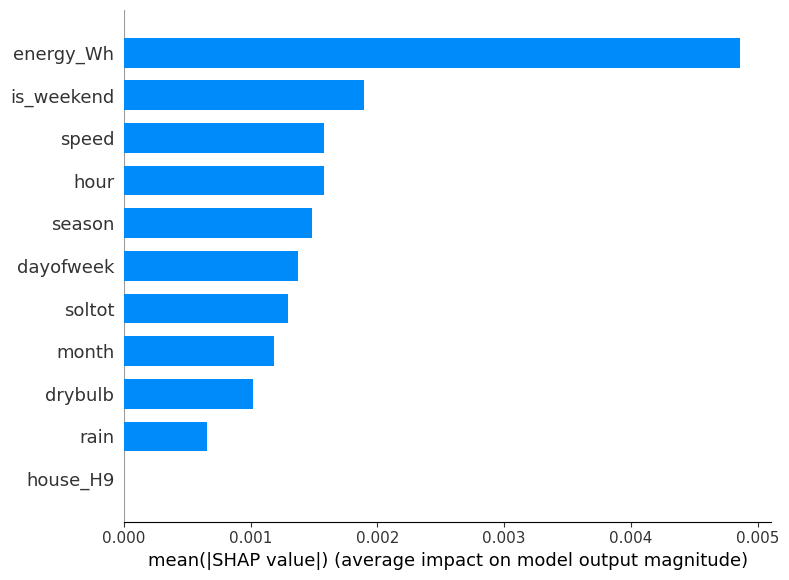

In [ ]:
# ===== SHAP on context features (regression head) — robust & fast =====
!pip -q install shap
import shap, numpy as np, pandas as pd

# Pick trained model
ecla_model = None
for cand in ["full", "model", "edge"]:
    if cand in globals():
        ecla_model = globals()[cand]
        break
assert ecla_model is not None, "Train ECLA first (e.g., variable named `full` or `model`)."

# Context feature names
try:
    ctx_feature_names = ctx_feat_names
except NameError:
    try:
        cols_all = list(df_scaled.columns)
        base_seq_names = set(['power_W'])
        ctx_feature_names = [c for c in cols_all if c not in base_seq_names]
    except Exception:
        ctx_feature_names = [f"ctx_{i}" for i in range(X_ctx_va.shape[1])]
# final guard
if len(ctx_feature_names) != X_ctx_va.shape[1]:
    ctx_feature_names = [f"ctx_{i}" for i in range(X_ctx_va.shape[1])]

# Evaluation slice (keep modest for speed)
Xe = X_ctx_va[:300].astype(np.float32)
Se_aligned = X_seq_va[:len(Xe)].astype(np.float32)  # sequence windows aligned to Xe length

# Summarize background with k-means (much faster than raw 200 rows)
bg = shap.kmeans(X_ctx_va.astype(np.float32), 50)

# Wrapper: tile/trim the sequence input to whatever batch size SHAP uses
def f_ctx(Xctx):
    n = Xctx.shape[0]
    if n <= 0:
        return np.array([], dtype=np.float32)
    # Repeat Se_aligned along batch dim to match n
    reps = (n + Se_aligned.shape[0] - 1) // Se_aligned.shape[0]
    seq = np.concatenate([Se_aligned] * reps, axis=0)[:n]
    y_reg_pred, _ = ecla_model.predict([seq, Xctx.astype(np.float32)], verbose=0)
    return y_reg_pred.reshape(-1)

# Explain
explainer = shap.KernelExplainer(f_ctx, bg)
# nsamples can be lowered (e.g., 80–120) for speed
shap_vals = explainer.shap_values(Xe, nsamples=120)
if isinstance(shap_vals, list):
    shap_vals = shap_vals[0]

# Numeric importance table
imp = pd.DataFrame({
    "feature": ctx_feature_names,
    "mean_abs_shap": np.mean(np.abs(shap_vals), axis=0)
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
display(imp.head(15))

# plots (uncomment in notebook)
shap.summary_plot(shap_vals, Xe, feature_names=ctx_feature_names)
shap.summary_plot(shap_vals, Xe, feature_names=ctx_feature_names, plot_type="bar")


In [ ]:
# ===== LOHO transfer test for ECLA (edge) — per-household windows, robust =====
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np, pandas as pd, tensorflow as tf

# Fallback for scikit-learn versions
def make_ohe():
    try:
        return OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    except TypeError:
        return OneHotEncoder(sparse=False, handle_unknown="ignore")

def prepare_fold_frames(df_in):
    base_cols = ["timestamp","household_id","power_W",
                 "hour","dayofweek","month","is_weekend","season",
                 "speed","drybulb","soltot","rain"]
    cols_exist = [c for c in base_cols if c in df_in.columns]
    d = (df_in[cols_exist]
         .dropna(subset=["timestamp","power_W"])
         .copy())
    d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")
    d = d.dropna(subset=["timestamp"])
    d = d.sort_values(["household_id","timestamp"]).reset_index(drop=True)
    return d

def build_windows_per_house(df_scaled_fold, seq_feat_names, seq_len=24, out_steps=1, group_col="household_id"):
    """
    Build windows *separately per household*, then concatenate.
    Assumes df_scaled_fold contains:
      - all scaled feature columns including 'power_W'
      - a non-scaled column `group_col` used solely for grouping
    """
    cols = list(df_scaled_fold.columns)
    feature_cols = [c for c in cols if c != group_col]            # used for model inputs
    assert "power_W" in feature_cols, "Scaled frame must include 'power_W' for y."

    seq_cols_idx = np.array([feature_cols.index(c) for c in seq_feat_names], dtype=int)
    ctx_cols_idx = np.array([i for i,c in enumerate(feature_cols) if c not in seq_feat_names], dtype=int)

    X_seq_all, X_ctx_all, Y_all = [], [], []

    for hh, g in df_scaled_fold.groupby(group_col, sort=False):
        A = g[feature_cols].values
        y = g["power_W"].values
        N = A.shape[0]
        if N < seq_len + out_steps:
            continue
        for i in range(N - seq_len - out_steps + 1):
            win = A[i:i+seq_len, :]
            X_seq_all.append(win[:, seq_cols_idx])
            X_ctx_all.append(A[i+seq_len-1, ctx_cols_idx])
            Y_all.append(y[i+seq_len:i+seq_len+out_steps])

    if len(X_seq_all) == 0:
        return np.empty((0, seq_len, len(seq_feat_names))), np.empty((0, len(ctx_cols_idx))), np.empty((0, out_steps))
    return np.array(X_seq_all), np.array(X_ctx_all), np.array(Y_all)

def loho_ecla_edge_transfer(df, households=None, seq_len=24, epochs=5, batch_size=256):
    d = prepare_fold_frames(df)
    houses_all = d["household_id"].unique().tolist()

    # Pick households to test (default: first 4 sufficiently long)
    if households is None:
        # choose those with at least 2*seq_len + 24 points
        lens = d.groupby("household_id").size().sort_values(ascending=False)
        candidates = lens[lens >= (2*seq_len + 24)].index.tolist()
        households = candidates[:4] if len(candidates) >= 4 else candidates

    print("LOHO candidates:", households)

    results = []
    if len(households) == 0:
        print("No households with enough data for LOHO.")
        return pd.DataFrame(results)

    # One-hot once for consistent columns
    ohe = make_ohe()
    ohe.fit(d[["household_id"]])
    house_cols = [f"house_{h}" for h in ohe.categories_[0]]

    for hh in households:
        train_df = d[d["household_id"] != hh].copy()
        val_df   = d[d["household_id"] == hh].copy()

        if len(train_df) < (seq_len + 24) or len(val_df) < (seq_len + 8):
            print(f"Skip {hh}: not enough rows (train={len(train_df)}, val={len(val_df)}).")
            continue

        # One-hot households → append
        Htr = ohe.transform(train_df[["household_id"]])
        Hva = ohe.transform(val_df[["household_id"]])

        trm = pd.concat([train_df.drop(columns=["household_id"]).reset_index(drop=True),
                         pd.DataFrame(Htr, columns=house_cols)], axis=1)
        vam = pd.concat([val_df.drop(columns=["household_id"]).reset_index(drop=True),
                         pd.DataFrame(Hva, columns=house_cols)], axis=1)

        # Scale on TRAIN only
        cols_for_scaling = list(trm.columns)  # includes 'power_W' + features + one-hots
        scaler_fold = MinMaxScaler()
        trm_s = pd.DataFrame(scaler_fold.fit_transform(trm), columns=cols_for_scaling)
        vam_s = pd.DataFrame(scaler_fold.transform(vam),   columns=cols_for_scaling)

        # Add group col back (not scaled) for grouping during windowing
        trm_s["household_id"] = train_df["household_id"].values
        vam_s["household_id"] = val_df["household_id"].values

        # Sequence uses at least 'power_W' history
        seq_feat_names = ['power_W']  # you can extend with short weather history
        X_seq_tr, X_ctx_tr, y_tr = build_windows_per_house(trm_s, seq_feat_names, seq_len, out_steps=1)
        X_seq_va, X_ctx_va, y_va = build_windows_per_house(vam_s, seq_feat_names, seq_len, out_steps=1)

        if len(X_seq_tr) < 32 or len(X_seq_va) < 16:
            print(f"Skip {hh}: insufficient windows (train_wins={len(X_seq_tr)}, val_wins={len(X_seq_va)}).")
            continue

        # Build & train edge model
        e_model = build_ecla_model(
            seq_len=seq_len,
            n_seq_features=X_seq_tr.shape[2],
            n_context=X_ctx_tr.shape[1],
            out_steps=1,
            edge_friendly=True,
            lr=5e-4
        )
        cb = [
            tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        ]
        e_model.fit([X_seq_tr, X_ctx_tr], {"y_reg": y_tr, "y_cls": (y_tr > np.quantile(y_tr, 0.8)).astype(np.float32)},
                    validation_data=([X_seq_va, X_ctx_va], {"y_reg": y_va, "y_cls": (y_va > np.quantile(y_va, 0.8)).astype(np.float32)}),
                    epochs=epochs, batch_size=batch_size, verbose=0, callbacks=cb)

        # Predict (scaled)
        y_pred_s, _ = e_model.predict([X_seq_va, X_ctx_va], verbose=0)
        y_pred_s = y_pred_s.reshape(-1); y_true_s = y_va.reshape(-1)

        # Inverse to original units (use train scaler stats)
        idx_pw = trm_s.columns.get_loc("power_W")
        pw_min, pw_max = scaler_fold.data_min_[idx_pw], scaler_fold.data_max_[idx_pw]
        y_true = y_true_s * (pw_max - pw_min) + pw_min
        y_pred = y_pred_s * (pw_max - pw_min) + pw_min

        fold_metrics = reg_metrics(y_true, y_pred)
        fold_metrics["ValHouse"] = hh
        results.append(fold_metrics)
        print(f"[LOHO Edge] House={hh}  MAE={fold_metrics['MAE']:.3f}  RMSE={fold_metrics['RMSE']:.3f}  "
              f"MAPE={fold_metrics['MAPE%']:.2f}%  R2={fold_metrics['R2']:.3f}")

    return pd.DataFrame(results)

# ---- Run LOHO (try a small subset first; set households=None to auto-pick by length) ----
df_loho = loho_ecla_edge_transfer(df, households=None, seq_len=24, epochs=5)

# Safe averaging
if df_loho.empty:
    print("LOHO produced no folds. Check the printed skip reasons above and try:\n"
          "- lowering seq_len (e.g., 12)\n- increasing epochs\n- selecting specific households with enough data\n"
          "- ensuring hourly resampling produced sufficient points per household.")
else:
    print("Avg LOHO:", df_loho[["MAE","RMSE","MAPE%","R2"]].mean().round(4).to_dict())
    display(df_loho.round(4))


LOHO candidates: ['H9']
Skip H9: not enough rows (train=0, val=8784).
LOHO produced no folds. Check the printed skip reasons above and try:
- lowering seq_len (e.g., 12)
- increasing epochs
- selecting specific households with enough data
- ensuring hourly resampling produced sufficient points per household.


In [ ]:
# ===== Consolidated results table (robust, with latencies & improvements) =====
import numpy as np
import pandas as pd
from math import isnan

rows = []

def safe_add_row(name, ytrue_var, ypred_var, latency_var=None):
    """
    Add a row if ytrue/ypred exist & are non-empty. Optionally attach latency.
    ytrue_var / ypred_var are variables (arrays/Series); pass them directly.
    """
    try:
        ytrue = np.asarray(ytrue_var).reshape(-1)
        ypred = np.asarray(ypred_var).reshape(-1)
        if ytrue.size == 0 or ypred.size == 0:
            return
        m = reg_metrics(ytrue, ypred)
        row = {"Model": name, **m}
        if latency_var is not None:
            # attach if it's a real number
            try:
                lv = float(latency_var)
                if np.isfinite(lv):
                    row["Latency_ms"] = lv
            except Exception:
                pass
        rows.append(row)
    except Exception as e:
        print(f"Skip row '{name}': {e}")

# ---- Try to add each model; only those that exist will be added ----
# Naive & MA(3)
try:
    safe_add_row("Naive(last)", y_true_va, y_naive, latency_var=globals().get("naive_latency_ms"))
except Exception as e:
    print("Naive missing:", e)

try:
    safe_add_row("MA(3)", y_true_va, y_ma3, latency_var=globals().get("ma3_latency_ms"))
except Exception as e:
    print("MA(3) missing:", e)

# ARIMA (per-household)
if "df_arima" in globals():
    try:
        safe_add_row("ARIMA per-household",
                     df_arima["y_true"].values, df_arima["y_pred"].values,
                     latency_var=globals().get("arima_latency_ms"))
    except Exception as e:
        print("ARIMA missing:", e)

# SVR / RF (classical)
try:
    safe_add_row("SVR", yb_va, y_svr, latency_var=globals().get("svr_latency_ms"))
except Exception as e:
    print("SVR missing:", e)

try:
    safe_add_row("RandomForest", yb_va, y_rf, latency_var=globals().get("rf_latency_ms"))
except Exception as e:
    print("RandomForest missing:", e)

# ECLA Full / Edge
try:
    safe_add_row("ECLA (full)", y_reg_true, y_reg_pred_full, latency_var=globals().get("lat_full_ms"))
except Exception as e:
    print("ECLA (full) missing:", e)

try:
    safe_add_row("ECLA (edge)", y_reg_true, y_reg_pred_edge, latency_var=globals().get("lat_edge_ms"))
except Exception as e:
    print("ECLA (edge) missing:", e)

# ---- Build DataFrame and compute improvements vs baseline ----
if len(rows) == 0:
    print("No models to summarize — ensure you ran the evaluations first.")
else:
    df_results = pd.DataFrame(rows)

    # choose baseline: ARIMA if available, otherwise Naive(last) if available
    baseline_name = None
    if "ARIMA per-household" in df_results["Model"].values:
        baseline_name = "ARIMA per-household"
    elif "Naive(last)" in df_results["Model"].values:
        baseline_name = "Naive(last)"

    if baseline_name is not None:
        base = df_results.loc[df_results["Model"] == baseline_name].iloc[0]
        for metric in ["RMSE", "MAE"]:
            df_results[f"Δ{metric}_vs_{baseline_name}_%"] = (
                (base[metric] - df_results[metric]) / base[metric] * 100.0
            )
    else:
        # no baseline available; leave improvement cols out
        pass

    # nice column order if present
    col_order = ["Model", "MAE", "RMSE", "MAPE%", "R2", "Latency_ms"]
    cols = [c for c in col_order if c in df_results.columns] + \
           [c for c in df_results.columns if c not in col_order]
    df_results = df_results[cols].sort_values("RMSE").reset_index(drop=True)

    display(df_results.round(4))

    # ---- Optional: classification head summary for ECLA on same val windows ----
    from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
    try:
        acc = (y_cls_true == (y_cls_prob >= 0.5)).mean()
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_cls_true, (y_cls_prob >= 0.5).astype(int), average="binary"
        )
        auc = roc_auc_score(y_cls_true, y_cls_prob)
        cls_row = pd.DataFrame([{
            "Model":"ECLA (classifier)",
            "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc
        }])
        display(cls_row.round(4))
    except Exception as e:
        print("Classifier metrics skipped:", e)

    # ---- Save for report ----
    df_results.to_csv("results_regression_comparison.csv", index=False)
    try:
        cls_row.to_csv("results_classification_ecla.csv", index=False)
    except:
        pass


,Model,MAE,RMSE,MAPE%,R2,Latency_ms,ΔRMSE_vs_ARIMA per-household_%,ΔMAE_vs_ARIMA per-household_%
0,ECLA (edge),1.4365,3.5529,1.747682e+10,0.6336,116.3956,34.6984,56.9777
1,RandomForest,1.8332,3.9406,3.090279e+10,0.6236,103.2014,27.5715,45.0973
2,Naive(last),1.6524,4.1338,2.076519e+10,0.5041,0.0043,24.0214,50.5133
3,SVR,2.0337,4.2608,2.681083e+10,0.5599,1.1445,21.6866,39.0933
4,MA(3),2.1848,4.7926,5.459957e+10,0.3334,0.0255,11.9127,34.5690
5,ARIMA per-household,3.3391,5.4407,1.666130e+11,0.1425,108.0783,0.0000,0.0000
6,ECLA (full),3.0317,6.1205,5.267163e+10,-0.0872,110.5775,-12.4930,9.2048


,Model,Accuracy,Precision,Recall,F1,AUC
0,ECLA (classifier),0.9492,0.8607,0.8905,0.8754,0.9741
